In [18]:
import numpy as np
from tqdm.notebook import tqdm
import trimesh
from queue import PriorityQueue
import matplotlib.pyplot as plt
from make_vtk import write_lines_to_vtk,write_points_to_vtk
from vtk_revise import read_vtk,write_vtk
from faster_generate_cone import generate_vectors_in_cone,plot_vectors_in_3d
# import cupy as cp

In [19]:
white = read_vtk('./AllCortexData/GS_CortexODE/SUBJ_001_MR_BL/surf/lh.CortexODE.white.vtk')
pial = read_vtk('./AllCortexData/GS_CortexODE/SUBJ_001_MR_BL/surf/lh.CortexODE.pial.vtk')

white_vertices = white['vertices']
white_faces = white['faces'][:,1:]

pial_vertices = pial['vertices']
pial_faces = pial['faces'][:,1:]

In [9]:
pair = [(w_v,p_v) for w_v,p_v in zip(white_vertices,pial_vertices)] 
write_lines_to_vtk(pair, f"./cone_data/test.vtk")

In [24]:
import trimesh
import numpy as np

# Load your target mesh
origin_mesh = trimesh.Trimesh(vertices=white_vertices, faces=white_faces)
target_mesh = trimesh.Trimesh(vertices=pial_vertices, faces=pial_faces)

# origin vertex normals
origin_directions = origin_mesh.vertex_normals.copy()
white2pial_dir = pial_vertices - white_vertices
dir_sign = (np.sum(white2pial_dir*origin_directions,axis=1) < 0)
origin_directions[dir_sign] *= -1


    

In [23]:

# Pre-compute all the cone directions for all origins
all_origins = []
all_directions = []

for idx in tqdm(range(len(white_vertices))):
    origin_pos = white_vertices[idx]
    origin_cone_directions = generate_vectors_in_cone(origin_directions[idx], 15, 50)
    all_origins.extend([origin_pos] * len(origin_cone_directions))
    all_directions.extend(origin_cone_directions)

# Find ray-mesh intersections for all origins and directions at once
locations, index_ray, index_tri = target_mesh.ray.intersects_location(ray_origins=all_origins, ray_directions=all_directions)




  0%|          | 0/142422 [00:00<?, ?it/s]

(26473084, 3)


In [41]:
# print(white_vertices.shape)
# print(origin_cone_directions.shape)
print(len(all_origins))    # 7121100
print(locations.shape)    # (26473084, 3)

print(len(index_ray))    # 26473084
print(index_ray)   # 최대가 7121100

print(np.where(0<=index_ray<=50))

7121100
(26473084, 3)
26473084
[      0       1       2 ... 7102004 7104065 7104989]
(array([0], dtype=int64),)


C:\Users\pari0\AppData\Local\Temp\ipykernel_15996\1159078627.py:9: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  print(np.where(0<=index_ray.any()<=50))


In [ ]:
# Now, process the results
pairs = []
thicknesses = []
not_intersect = []

# 'idx' is a factor to know which original vertex we are looking at. 
# This will change every 50 iterations (since there are 50 samples for each vertex).
for idx in tqdm(range(0, len(all_origins), 50)):
    subset_locations = locations[idx: idx+50]
    subset_origin = all_origins[idx]
    
    distances = [np.linalg.norm(loc - subset_orgin) for loc in subset_locations]

    if distances:
        min_distance_index = np.argmin(distances)
        closest_location = subset_locations[min_distance_index]
        closest_distance = distances[min_distance_index]
        
        pairs.append((subset_origin, closest_location))
        thicknesses.append(closest_distance)
        
        # if closest_distance > 7:
        #     thicknesses.append(float('nan'))
        #     not_intersect.append(subset_origin)
        # else : 
        #     pairs.append((subset_origin, closest_location))
        #     thicknesses.append(closest_distance)
    else:
        thicknesses.append(float('nan'))
        not_intersect.append(subset_origin)


In [22]:
thicknesses = np.array(thicknesses)
white['new_thickness'] = thicknesses
write_vtk(white,'./cone_data/subject1_lh_white.vtk')
write_lines_to_vtk(pairs, f"./cone_data/pair_line.vtk")
write_points_to_vtk(not_intersect,f"./cone_data/not_intersect_point.vtk",color=(255,0,0))


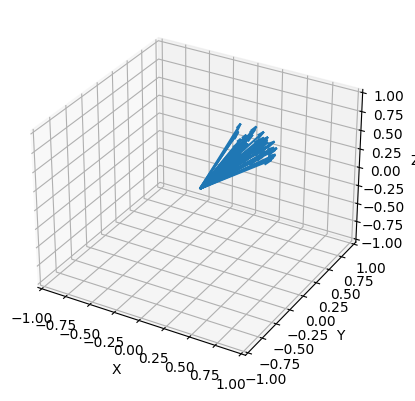

In [8]:

a = np.array([0,1,0])
ori = np.array([0,0,0])
origin_cone_directions = generate_vectors_in_cone(a, 15, 50)

plot_vectors_in_3d(origin_cone_directions,ori)
